# Complex German Legal Case Classification
Jeremy Proz

## Abstract
For my master thesis, I regularly come across legal texts in German concerning legal cartel accusations. These are fact-heavy texts with very complex conclusions located in various parts of the text. I usually have very little interest in reading the entire cases. Instead, I would only like to know if the acusee was convicted i.e. if the court approved the damages. Of course, I could simply pass the texts into a summarization model, but I would still need to read each of the summaries for many many cases. I would need a model to classify each legal text as either "convicted" or not. This would greatly speed up the research process.

There happens to be a very fitting dataset of labeled Swiss legal cases. Let's train a german BERT to do the task! We will also optimize computing power as much as possible to train and run the model on a local GPU (hey I don't want to pay Google and I have an ok GPU).

## Important: there are 3 models to train. Be aware when running on colab!

# Dependencies
To train the models, I used a local conda environment with tensorflow 2.10 along with the necessary dependencies. This was to leverage local GPU power and avoid paying Google. Run the following cell in order to run this on Colab.

In [1]:
!pip install -qq datasets transformers[sentencepiece]

The following cell confirms if a GPU can be used.

In [2]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print(f"Default GPU Device: {tf.test.gpu_device_name()}")
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# Dataset

In [3]:
from datasets import load_dataset

raw_data = load_dataset("swiss_judgment_prediction", "de")

In [4]:
raw_data

DatasetDict({
    train: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 35458
    })
    validation: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 9725
    })
})

In [5]:
# Features
raw_data["train"].features

{'id': Value(dtype='int32', id=None),
 'year': Value(dtype='int32', id=None),
 'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['dismissal', 'approval'], id=None),
 'language': Value(dtype='string', id=None),
 'region': Value(dtype='string', id=None),
 'canton': Value(dtype='string', id=None),
 'legal area': Value(dtype='string', id=None),
 'source_language': Value(dtype='string', id=None)}

In [6]:
set(raw_data["train"]["label"])

{0, 1}

In [7]:
# create a dataframe to easily find an examle of a relevant case
import pandas as pd
train = pd.DataFrame(raw_data["train"])

In [8]:
# how many cases include the word cartel?
len(train[train["text"].str.lower().str.contains("kartell")])

33

In [9]:
# example case
cartel_ex = train[train["text"].str.lower().str.contains("kartell")].sample().iloc[0]
print(cartel_ex)

id                                                             27691
year                                                            2009
text               Sachverhalt: A. A.a Am 24. Juli 2006 eröffnete...
label                                                              0
language                                                          de
region                                                    Federation
canton                                                            ch
legal area                                                public law
source_language                                                  n/a
Name: 22044, dtype: object


In [10]:
print(cartel_ex["text"])

Sachverhalt: A. A.a Am 24. Juli 2006 eröffnete das Sekretariat der Wettbewerbskommission gegen die Telekurs Multipay AG wegen des Verdachts des Missbrauchs einer marktbeherrschenden Stellung im Zusammenhang mit der Währungsumrechnungsfunktion in Kreditkartenterminals ("Dynamic Currency Conversion, DCC") eine Vorabklärung. Gestützt auf den Schlussbericht vom 10. Januar 2007 leitete sie am 17. Januar 2007 im Einverständnis mit dem Präsidenten der Wettbewerbskommission (WEKO) eine kartellrechtliche Untersuchung gegen die Telekurs Multipay AG und die Telekurs Card Solutions AG ein (Verfahren 32-0205). Die Verfahrensaufsicht oblag Olivier Schaller als zuständigem Vizedirektor. A.b Am 14. Mai 2007 orientierte der gemeinsame Rechtsvertreter der SWX Group (SWX), der SIS Swiss Financial Services Group (SIS) und der Telekurs Holding AG das Sekretariat der WEKO telefonisch darüber, dass die drei Unternehmen einen Zusammenschluss planten. Am 11. Juni 2007 präsentierten Vertreter der Fusionspartner

In [11]:
print(cartel_ex["label"])

0


In [12]:
# save some RAM
del train

# Common text classifier
There are multiple approaches to decide if the conclusion of the case was conviction or not:
- text classification
- text summarization. This allows for more flexible answers. However, it also requires more computing power to train with a relatively large dataset.
- natural language inference. A single case may consist of multiple charges, for which only a part may be true. Classification may therefore be too rigid. However, this field is newer than text classification and public light-weight german NLI models do not exist on hf.
- other language-based approaches...

Because the dataset encourages us to approach this from a text classification task perspective (due to the presence of numerical labels) we will forego the other approaches. Note that training an NLI in German could have also been a goal of this project.

## Preprocess


*   Tokenize and verify the number of tokens
*   Keep only the token columns and labels



In [128]:
from transformers import AutoTokenizer

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-german-cased')

In [14]:
tokenizer("ein kleines Beispiel hier")

{'input_ids': [102, 143, 8615, 2128, 651, 103], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [16]:
columns = raw_data["train"].column_names
columns.remove("label")
print(columns)

['id', 'year', 'text', 'language', 'region', 'canton', 'legal area', 'source_language']


Map:   0%|          | 0/35458 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (894 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/4705 [00:00<?, ? examples/s]

Map:   0%|          | 0/9725 [00:00<?, ? examples/s]

(array([2.5849e+04, 8.2950e+03, 1.0600e+03, 1.7900e+02, 4.3000e+01,
        1.6000e+01, 5.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([5.0000e+00, 7.5530e+02, 1.5056e+03, 2.2559e+03, 3.0062e+03,
        3.7565e+03, 4.5068e+03, 5.2571e+03, 6.0074e+03, 6.7577e+03,
        7.5080e+03]),
 <BarContainer object of 10 artists>)

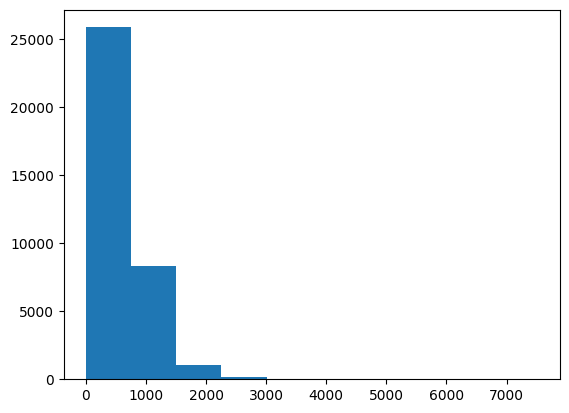

In [80]:
def tokenize_and_preprocess(dataset):
  tokenized_inputs = tokenizer(dataset["text"], truncation=False) # no truncation
  return tokenized_inputs

tokenized_data = raw_data.map(tokenize_and_preprocess,
                              batched=True,
                              remove_columns=columns,
                              )

token_quantity = []

for row in tokenized_data["train"]["input_ids"]:
  token_quantity.append(len(row))

plt.hist(token_quantity)

In [83]:
print(max(token_quantity))

7508


The maximum amount of tokens process-able by distilbert is 512 and many datasets seem to overshoot this limit (by a lot!) Our results will likely be curbed if we only classify using the first 512 tokens of each text but let's try it.

In [15]:
def tokenize_and_preprocess(dataset):
  tokenized_inputs = tokenizer(dataset["text"], truncation=True) # some inputs are larger than the 512 allowed tokens
  return tokenized_inputs

In [17]:
tokenized_data = raw_data.map(tokenize_and_preprocess,
                              batched=True,
                              remove_columns=columns,
                              )

Map:   0%|          | 0/9725 [00:00<?, ? examples/s]

In [18]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 35458
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 9725
    })
})

## Batches
A collator is necessary here to ensure that each input text in a batch has the same length by adding padding where necessary. Here, padding is essential and we choose a collator accordingly.

In [21]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, return_tensors="tf"
)

tf_datasets = dict()

splits = ["train", "validation", "test"]

for split in splits:
  tf_datasets[split] = tokenized_data[split].to_tf_dataset(
      columns=["attention_mask", "input_ids", "labels"],
      collate_fn=data_collator,
      shuffle=True,
      batch_size=16,
  )

In [22]:
tf_datasets

{'train': <PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>,
 'validation': <PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>}

## Load Model

In [23]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-german-cased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [24]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66808320  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 67,400,450
Trainable params: 67,400,450
Non-trainable params: 0
_________________________________________________________________


Let's optimize memory usage by freezing the distilbert layer. Although this may be sub-optimal for a domain-specific dataset such as the legal cases of our dataset, it will enable us to run it within reasonable memory space.

In [25]:
model.distilbert.trainable = False

In [51]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66808320  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 67,400,450
Trainable params: 592,130
Non-trainable params: 66,808,320
_________________________________________________________________


In [21]:
from transformers import create_optimizer
import tensorflow as tf

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

num_epochs = 3
num_train_steps = len(tf_datasets['train']) * num_epochs

optimizer, schedule = create_optimizer(
  init_lr=2e-5,
  num_warmup_steps=0,
  num_train_steps=num_train_steps,
  weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


NameError: name 'tf_datasets' is not defined

In [27]:
%%time
model.fit(
  tf_datasets['train'],
  validation_data=tf_datasets['validation'],
  epochs=num_epochs,
)

Epoch 1/3
2217/2217 [==============================] - 1292s 578ms/step - loss: 0.5422 - val_loss: 0.5053
Epoch 2/3
2217/2217 [==============================] - 1262s 569ms/step - loss: 0.5362 - val_loss: 0.5040
Epoch 3/3
2217/2217 [==============================] - 1314s 593ms/step - loss: 0.5346 - val_loss: 0.5034
CPU times: total: 23min 16s
Wall time: 1h 4min 55s


## Evaluation

In [66]:
import numpy as np

all_predictions = []
all_labels = []

for batch in tf_datasets['test']:
  logits = model.predict_on_batch(batch)["logits"]
  labels = batch["labels"]
  predictions = np.argmax(logits, axis=-1)
  for prediction, label in zip(predictions, labels):
      all_predictions.append(prediction)
      all_labels.append(label)

In [78]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8030848329048843
Precision: 0.40154241645244215
Recall: 0.5
F1 Score: 0.4453949244368406
Confusion Matrix:
[[7810    0]
 [1915    0]]


C:\Users\jerep\anaconda3\envs\tf2.10\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Unfortunately, our model has learned to optimize accuracy by only predicting 0s. Oops. A few possible reasons:
- truncating removes too much information
- a text classifier analysis may not be very suited to classify a recount of events into "approved" (convicted) or not.

The model truncated the last bit of text in most inputs. It is very likely that this hides the most important part of a lot of reports: the concluding sentences.

Let's attempt to avoid this problem.

# Second attempt - chunking
Let's try to optimize our training in a few different ways:
- simple chunking by splitting each text into chunks of 512 tokens (sometimes cutting full sentences) with the same label. Of course some context will be lost, but hey my humble laptop won't handle more complex chunking methods such as overlapping chunks. The dataset size will already grow by a lot.
- adam optimizer. Perhaps we will more quickly converge with a better optimizer.
- optimize batch size with the rule of thumb of square root of the number of observations (if memory allows it)
- use a different loss function, namely binary cross entropy which is ideal for binary classification

## Preprocessing

In [39]:
from datasets import Dataset, DatasetDict

In [41]:
def tokenize_and_preprocess(dataset, max_length=510):
    # Container for the chunked observations
    chunked_inputs = {'input_ids': [], 'attention_mask': [], 'label': []}
    
    for text, label in zip(dataset["text"], dataset["label"]):
        # Tokenize without truncation and without the CLS and SEP tokens
        tokenized = tokenizer(text, truncation=False, add_special_tokens=False)

        # Calculate the number of chunks needed for each text
        total_tokens = len(tokenized['input_ids'])
        num_chunks = (total_tokens // max_length) + (total_tokens % max_length > 0)

        for i in range(num_chunks):
            # Calculate chunk start and end indices
            chunk_start = i * max_length
            chunk_end = min((i + 1) * max_length, total_tokens)
            
            # Slice the tokenized output to get the current chunk
            chunk_input_ids = tokenized['input_ids'][chunk_start:chunk_end]
            chunk_attention_mask = tokenized['attention_mask'][chunk_start:chunk_end]
            
            # Add special tokens (CLS and SEP for BERT-based models)
            chunk_input_ids = [tokenizer.cls_token_id] + chunk_input_ids + [tokenizer.sep_token_id]
            chunk_attention_mask = [1] * len(chunk_input_ids)  # Update attention mask
            
            # Append the chunk and its label to the container
            chunked_inputs['input_ids'].append(chunk_input_ids)
            chunked_inputs['attention_mask'].append(chunk_attention_mask)
            chunked_inputs['label'].append(label)
    
    return Dataset.from_dict(chunked_inputs)

In [42]:
# Assuming raw_data is a DatasetDict with multiple sets like 'train', 'validation'
tokenized_data_datasets = {split: tokenize_and_preprocess(raw_data[split]) for split in raw_data.keys()}

In [43]:
tokenized_data_datasets

{'train': Dataset({
     features: ['input_ids', 'attention_mask', 'label'],
     num_rows: 60622
 }),
 'validation': Dataset({
     features: ['input_ids', 'attention_mask', 'label'],
     num_rows: 7304
 }),
 'test': Dataset({
     features: ['input_ids', 'attention_mask', 'label'],
     num_rows: 15465
 })}

In [45]:
# Convert the processed datasets back into a DatasetDict
tokenized_data = DatasetDict(tokenized_data_datasets)
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 60622
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 7304
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 15465
    })
})

In [53]:
print(len(tokenized_data["train"]))
batch_size = round(len(tokenized_data["train"]) ** 0.5)
print(batch_size)

60622
246


Ok this batch size will blow my memory to the moon so let's keep it to 16... shame

## Batches

In [48]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, return_tensors="tf"
)

tf_datasets = dict()

splits = ["train", "validation", "test"]

for split in splits:
  tf_datasets[split] = tokenized_data[split].to_tf_dataset(
      columns=["attention_mask", "input_ids", "labels"],
      collate_fn=data_collator,
      shuffle=True,
      batch_size=16,
  )

In [49]:
tf_datasets

{'train': <PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>,
 'validation': <PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>}

## Load and Train

In [63]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-german-cased', num_labels=2)
model.distilbert.trainable = False

import tensorflow as tf
model.compile(optimizer="adam", loss='binary_crossentropy')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [64]:
%%time
model.fit(
  tf_datasets['train'],
  validation_data=tf_datasets['validation'],
  epochs=3,
)

Epoch 1/3
3789/3789 [==============================] - 2076s 546ms/step - loss: 3.6867 - val_loss: 3.3029
Epoch 2/3
3789/3789 [==============================] - 2139s 565ms/step - loss: 3.6867 - val_loss: 3.3029
Epoch 3/3
3789/3789 [==============================] - 2025s 534ms/step - loss: 3.6867 - val_loss: 3.3029
CPU times: total: 36min 52s
Wall time: 1h 44min 1s


## Evaluation

In [66]:
import numpy as np

all_predictions = []
all_labels = []

for batch in tf_datasets['test']:
  logits = model.predict_on_batch(batch)["logits"]
  labels = batch["labels"]
  predictions = np.argmax(logits, axis=-1)
  for prediction, label in zip(predictions, labels):
      all_predictions.append(prediction)
      all_labels.append(label)

In [67]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

C:\Users\jerep\anaconda3\envs\tf2.10\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.20892337536372454
Precision: 0.10446168768186227
Recall: 0.5
F1 Score: 0.17281771501925547
Confusion Matrix:
[[    0 12234]
 [    0  3231]]


The problem persists but in the opposite direction... it seems the loss function is penalizing false negatives so much that it is now worth estimating all predictions as positives. a few potential problems:
- since truncating did not correctly classify the texts, it is certain that at least the first chunk per observation is wrongly guessed. The very simple chunking approach may be too simplistic to capture the information that is actually important: was the party convicted!? Perhaps even to a human, these features cannot tell anything about conviction.
- perhaps overfitting may be part of the problem? This is difficult to judge. But hey at least there should not be any leakage (that I am aware of)!

There are multiple approaches to the chunking problem and we will explore a more "lightweight" and creative solution in the next section.

# Third attempt - Text summarization and classification
To avoid training very large models, we will train the same model but with a twist...

In class, we discussed the importance of encoders. Ideally, we would be able to encode our large texts to some smaller sequence while retaining the sense of the text (actually this is already the concept behind our classifier). I believe this problem is beyond the scope of this project however. We will instead find a lightweight workaround.

Instead of traditional chunking, we will use an off-the-shelf model to attempt to summarize each long text. We are still constrained by the dreaded 512 tokens limit in our summarizer so we will be creative in our preprocessing. In a first step, each chunk will be passed to the summarizer. Then, each summary will further be passed to the same summarizer to get a single summary per observation. Finally, we will train the same model on the final summaries!

If each chunk summary is maxed out to 30 tokens and our final summary can accomodate 510 tokens (+ the two special tokens), our final summarizer can process 510//30=17 summaries. Moreover, 17 summaries is equivalent to 17*510=8670 tokens. Our largest text is 7502 tokens, so we should be able to capture all the information with chunk summaries of size 30.

However, to keep this lightweight, we will have to reduce our training size drastically. Our dataset will therefore have much more variance. Moreover, our model will be trained to interpret summaries and may therefore fail to capture some of the complexities of legal texts.

## Preprocessing
Ideally, Huggingface's pipeline function would be used. However, since we need to tokenize the text already to split it into chunks, we will have to load the model and use it on the tokenized texts.

In [13]:
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from datasets import Dataset, DatasetDict

summarizer = TFAutoModelForSeq2SeqLM.from_pretrained('Shahm/t5-small-german')
tokenizer = AutoTokenizer.from_pretrained('Shahm/t5-small-german')

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [139]:
example_tokenized = tokenizer(raw_data["train"][0]["text"], truncation=True, return_tensors="tf")
example_tokenized

{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[   71,     5,    18,   660, 23652, 14060,    15,   584,     5,
          834,   615,  3646,  1300,  1600, 12698,     3, 16512, 20551,
         1411,   501, 21452,    52,  5736,  2434,   468,    74, 14533,
           71,     5,   834,  8859, 19709,    64,   256,  7077,   645,
         7974,   346, 12470,    89,    17,  7342,    41,   567,     9,
         3997,  5269,    61,   703,  2636,  5541,   468,   665,   493,
        10674,   425,     7,  7691,    46,  5371, 16570,     6,   501,
            3,    49,   183,  5477, 17480,  9957,    16,  7005,  6050,
            3,  2683, 14216,  7517,   155,   324,  7844,   266, 25508,
         9433,   450,   256,  5728,    93,  1309,    35,  7734,  3878,
         5768,     7,     3,    49,  4250,    17,     5,   316,   781,
           40,  6706,   425,  1177,   183,  2208,     5, 17480,  9957,
        21835, 25508,  8607,    17,  6329,  5499,   548,  9143,    41,
         2703, 

In [140]:
summary_sequence = summarizer.generate(example_tokenized["input_ids"], max_length=30, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_sequence[0], skip_special_tokens=True)
summary

'Der 1955 geborene V._ war seit 1. September 1986 technischer Kaufmann bei der Firma A._ AG.'

sehr gut.

In [138]:
tokenizer.special_tokens_map

{'eos_token': '</s>',
 'unk_token': '<unk>',
 'pad_token': '<pad>',
 'additional_special_tokens': ['<extra_id_0>',
  '<extra_id_1>',
  '<extra_id_2>',
  '<extra_id_3>',
  '<extra_id_4>',
  '<extra_id_5>',
  '<extra_id_6>',
  '<extra_id_7>',
  '<extra_id_8>',
  '<extra_id_9>',
  '<extra_id_10>',
  '<extra_id_11>',
  '<extra_id_12>',
  '<extra_id_13>',
  '<extra_id_14>',
  '<extra_id_15>',
  '<extra_id_16>',
  '<extra_id_17>',
  '<extra_id_18>',
  '<extra_id_19>',
  '<extra_id_20>',
  '<extra_id_21>',
  '<extra_id_22>',
  '<extra_id_23>',
  '<extra_id_24>',
  '<extra_id_25>',
  '<extra_id_26>',
  '<extra_id_27>',
  '<extra_id_28>',
  '<extra_id_29>',
  '<extra_id_30>',
  '<extra_id_31>',
  '<extra_id_32>',
  '<extra_id_33>',
  '<extra_id_34>',
  '<extra_id_35>',
  '<extra_id_36>',
  '<extra_id_37>',
  '<extra_id_38>',
  '<extra_id_39>',
  '<extra_id_40>',
  '<extra_id_41>',
  '<extra_id_42>',
  '<extra_id_43>',
  '<extra_id_44>',
  '<extra_id_45>',
  '<extra_id_46>',
  '<extra_id_47>',
 

Special tokens are quite a bit different here. No beginning of sequence special token but an end of sequence eos_token.

In [142]:
tokenizer.eos_token_id

1

In [19]:
from tqdm import tqdm


def chunked_summarize(dataset, max_length=511):
    # Container for the chunked observations
    chunked_inputs = {'text': [], 'label': []}
    
    for text, label in tqdm(zip(dataset["text"], dataset["label"])):
        chunk_summaries = ""
        # Tokenize without truncation and without the CLS and SEP tokens
        tokenized = tokenizer(text, truncation=False, return_tensors="tf") # tensor

        # Calculate the number of chunks needed for each text
        total_tokens = tf.size(tokenized["input_ids"]).numpy()
        num_chunks = (total_tokens // max_length) + (total_tokens % max_length > 0)

        for i in range(num_chunks):
            # Calculate chunk start and end indices
            chunk_start = i * max_length
            chunk_end = min((i + 1) * max_length, total_tokens)
            
            # Slice the tokenized output to get the current chunk
            chunk_input_ids = tokenized['input_ids'][:,chunk_start:chunk_end] # tensor
            
            # Add special tokens (CLS and SEP for BERT-based models)
            if i != num_chunks:
                chunk_input_ids = tf.concat([chunk_input_ids, tf.constant([[1]])], axis=1) # tensor

            # Summarize
            summary_sequence = summarizer.generate(input_ids=chunk_input_ids, max_length=30, num_beams=4, early_stopping=True)
            summary = tokenizer.decode(summary_sequence[0], skip_special_tokens=True)
            
            # Append the chunk summary to the texts
            chunk_summaries += summary

        # Finally, create a last summary and assign it to the dataset. Truncation just in case. Max length argument can be relaxed.
        tokenized_chunk_summaries = tokenizer(chunk_summaries, truncation=True, return_tensors="tf")
        summary_sequence_final = summarizer.generate(input_ids=tokenized_chunk_summaries['input_ids'], max_length=150, num_beams=4, early_stopping=True)
        summary_final = tokenizer.decode(summary_sequence_final[0], skip_special_tokens=True)

        chunked_inputs["text"].append(summary_final)
        chunked_inputs["label"].append(label)
        
    return Dataset.from_dict(chunked_inputs)

In [20]:
summarized_data_datasets = {split: chunked_summarize(raw_data[split]) for split in raw_data.keys()}
summarized_data = DatasetDict(summarized_data_datasets)
summarized_data

9it [02:13, 14.80s/it]


KeyboardInterrupt: 

With 15 seconds per iteration, this approach will take me 15sec * 49000 observations = 204 hours... let's shorten this time by 200 by shortening our raw data.

In [25]:
def reduce_dataset_size(split):
    # Calculate the number of samples to select (1/200 of the dataset size)
    num_samples = len(split) // 200
    
    # Shuffle the dataset split
    split = split.shuffle(seed=42)
    
    # Select a subset of the dataset split
    subset = split.select(range(num_samples))
    
    return subset

# Apply the reduction process to each split
shortened_raw_data = {split_name: reduce_dataset_size(split) for split_name, split in raw_data.items()}

In [26]:
shortened_raw_data

{'train': Dataset({
     features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
     num_rows: 177
 }),
 'validation': Dataset({
     features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
     num_rows: 23
 }),
 'test': Dataset({
     features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
     num_rows: 48
 })}

In [34]:
print(f"Minutes to preprocess: {15*(177+23+48)/60}")

Minutes to preprocess: 62.0


In [40]:
summarized_data_datasets = {split: chunked_summarize(shortened_raw_data[split]) for split in shortened_raw_data.keys()}
summarized_data = DatasetDict(summarized_data_datasets)
summarized_data

177it [43:11, 14.64s/it]
23it [05:22, 14.03s/it]
48it [11:43, 14.66s/it]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 177
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 23
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 48
    })
})

In [45]:
summarized_data["train"][40]

{'text': 'Die La Suisse Versicherungen schliesst auf Abweisung der Verwaltungsgerichtsbeschwerde. Das Bundesamt für Soziales schließt auf Abweisung der Verwaltungsgerichtsbeschwerde.',
 'label': 1}

Seems very interpretable. This is exactly what I am looking for.

In [24]:
from transformers import AutoTokenizer

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-german-cased')

columns = summarized_data["train"].column_names
columns.remove("label")



def tokenize_and_preprocess(dataset):
  tokenized_inputs = tokenizer(dataset["text"], padding="max_length", max_length=500)
  return tokenized_inputs

tokenized_data = summarized_data.map(tokenize_and_preprocess,
                                     batched=True,
                                     remove_columns=columns,
                                    )

tokenized_data

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 177
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 23
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 48
    })
})

## Batches

This time let us leverage the rule of thumb for batch size! Also let's skip the collator.

In [58]:
train_dataset = tokenized_data['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    batch_size=13,
)

validation_dataset = tokenized_data['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=False,
    batch_size=13,
)

test_dataset = tokenized_data['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=False,
    batch_size=13,
)

## Load and Train
Since our dataset is now very small, let's at least increase the number of epochs. To avoid overfitting, let's additionally implement an early stopping mechanism.

In [25]:
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-german-cased', num_labels=2)
model.distilbert.trainable = False

# Prepare the model for training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), # let's be stricter on the learning rate as well
              loss='binary_crossentropy',
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [26]:
%%time

model.fit(train_dataset, validation_data=validation_dataset, epochs=200, callbacks=[early_stopping])

Epoch 1/200
14/14 [==============================] - 14s 529ms/step - loss: 1.0246 - accuracy: 0.6893 - val_loss: 0.4660 - val_accuracy: 0.1739
Epoch 2/200
14/14 [==============================] - 5s 373ms/step - loss: 0.5579 - accuracy: 0.2768 - val_loss: 0.4959 - val_accuracy: 0.1739
Epoch 3/200
14/14 [==============================] - 5s 396ms/step - loss: 0.5438 - accuracy: 0.3729 - val_loss: 0.4614 - val_accuracy: 0.4783
Epoch 4/200
14/14 [==============================] - 5s 389ms/step - loss: 0.6005 - accuracy: 0.4633 - val_loss: 0.4381 - val_accuracy: 0.6957
Epoch 5/200
14/14 [==============================] - 5s 372ms/step - loss: 0.5357 - accuracy: 0.6328 - val_loss: 0.4704 - val_accuracy: 0.6957
Epoch 6/200
14/14 [==============================] - 5s 375ms/step - loss: 0.5243 - accuracy: 0.5085 - val_loss: 0.4457 - val_accuracy: 0.4348
Epoch 7/200
14/14 [==============================] - 5s 377ms/step - loss: 0.5202 - accuracy: 0.4972 - val_loss: 0.4406 - val_accuracy: 0.434

In [27]:
model.save_pretrained(r"C:\Users\jerep\OneDrive\Documents\Deep Learning\sentiment_classifier_summarized")

## Evaluation

In [71]:
import numpy as np

all_predictions = []
all_labels = summarized_data["test"]["label"]

for batch in test_dataset:
  logits = model.predict_on_batch(batch)["logits"]
  predictions = tf.argmax(logits, axis=-1)
  for prediction in predictions.numpy():
      all_predictions.append(prediction)

In [72]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.4375
Precision: 0.4375
Recall: 0.4208791208791209
F1 Score: 0.40632157581310124
Confusion Matrix:
[[16 19]
 [ 8  5]]


Finally some result! It's not brilliant but this is expected from such a small training dataset.

# Gradio

In [73]:
!pip install -q gradio

In [76]:
num2label = {0:"dismissed", 1:"approved"}

def extract_judgement_outcome(legal_text):
  tokenized_text = tokenizer(legal_text, return_tensors='np')
  logits = model.predict(tokenized_text['input_ids'])
  prob = tf.nn.softmax(logits['logits'], axis=None)[0].numpy()
  confidences = {num2label[i]: float(prob[i]) for i in range(len(prob))}
  return confidences

In [77]:
extract_judgement_outcome("Die La Suisse Versicherungen schliesst auf Abweisung der Verwaltungsgerichtsbeschwerde. Das Bundesamt für Soziales schließt auf Abweisung der Verwaltungsgerichtsbeschwerde.")

1/1 [==============================] - 0s 92ms/step


{'dismissed': 0.5018596053123474, 'approved': 0.4981403946876526}

In [79]:
import gradio as gr
import random

demo = gr.Interface(fn=extract_judgement_outcome,
                    inputs='text',
                    outputs=gr.Label(num_top_classes=2),
                    examples=[random.choice(summarized_data['test']['text']) for _ in range(10)])

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 76ms/step


## Outlook
Although I ran into a lot of troubles with large texts and with processing power, if I had another month, I would preprocess the entire dataset with the text summarization to have a larger training set. If I also had some cash to spare, I would train the entire distilbert model (66 mio parameters) to enable it to additionally learn legal the legal slang.

# Model Card for German Legal Case Text Classification
This model assigns a simple classification label of whether a legal complaint was dismissed or approved by the court in a complex legal summary of facts in German.

## Model Description
- Developed by: Jeremy Proz
- Model type: text classification
- Language(s) (NLP): German
- Finetuned from model: distilbert-base-german-cased

## Uses
Can be used to classify legal German texts as either dismissed or approved. This is a niche use case where one may be in need to automatically quantify a series of German court proceedings.

## Bias, Risk and Limitations
This model was trained on Swiss court data. It is therefore likely that courts around the world will describe the events differently or be submitted to different laws.

## Training Details
### Training Data
a subset of summarized data from rcds

lower_court_insertion_swiss_judgment_predicti using Shahm/t5-small-german
### Training Procedure
The texts were chunked and summarized before being fed into the distilbert model with a frozen transformer layer.
Hyperparameters inlcude:
- adam optimizer with learning rate of 5e-5
- batches of 13
- 200 epochs
- early callbacks after 20 epochs

## Evaluation
- Accuracy: 0.4375- 
Precision: 0.4375- 
Recall: 0.420879120879120- 9
F1 Score: 0.40632157581310

## Model Card Contact
"jeremy.proz@unifr.ch"124n 

In [15]:
classifier = pipeline("zero-shot-classification", model="Sahajtomar/German_Zeroshot")

config.json:   0%|          | 0.00/823 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
candidate_labels = ["Kartell", "Geldwäsche", "Korruption", "Betrug", "andere"]
hypothesis_template = "In deisem geht es um {}."

classifier(
    cartel_ex["text"],
    candidate_labels=candidate_labels,
    hypothesis_template=hypothesis_template
)

{'sequence': 'Sachverhalt: Sachverhalt: A. Die Y._ (Klägerin und Berufungsbeklagte) ist eine Branchenorganisation im Sinne von Art. 8 des Bundesgesetzes über die Landwirtschaft (LwG, SR 910.1) und ist als Verein im Sinne von Art. 60 ff. ZGB organisiert. Sie wurde im Jahre 1997 gegründet und bezweckt, die Interessen der Schweizer Emmentaler-Käsewirtschaft in gemeinsamer Selbsthilfe von Michproduzenten, Käsereien sowie Handels- und Verarbeitungsunternehmen zu wahren. Sie vereinigt mit ihren 710 Mitgliedern rund 98 % der Marktteilnehmer und der Käsemenge (Stand Januar 2002). Im Rahmen ihres Vereinszwecks fördert sie den langfristigen und nachhaltigen Absatz von Emmentaler Käse und unternimmt zu diesem Zweck diverse Marketing- und Qualitätsförderungsmassnahmen wie Werbung, Öffentlichkeitsarbeit, Verkaufsförderung, Sponsoring, Messeorganisation, Unterhalt einer Schaukäserei, Qualitätsüberwachung, Bewirtschaftung der Käsereimarke und Einführung einer geschützten Ursprungsbezeichnung. Die X._